In [26]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.integrate import quad
from SED_Model import lrt_model
from astropy.stats import sigma_clip

In [12]:
def SF(dt, Mi):
    A = 1.0
    B = 0.024
    C = 0.3
    return A*(1+B*Mi)*(dt/6231.)**C

In [13]:
def func(x, mag_diff, delta_c, mag_diff_err2):
    return np.exp(-np.abs(mag_diff-x)/delta_c) * np.exp(-0.5*(x**2/mag_diff_err2))

In [14]:
def prob(mag_diff, mag_diff_err2, delta_c):
    p = quad(func, -np.inf, np.inf, args=(mag_diff, delta_c, mag_diff_err2))[0]
    return p

In [15]:
def log_p(dt, Mi, mag_diff, mag_diff_err2):
    delta_c = SF(dt, Mi)/2**0.5
    lp = 0.
    for k in range(len(mag_diff)):
        p = prob(mag_diff[k], mag_diff_err2[k], delta_c[k])
        lp += np.log(p)
    lp -= np.log(delta_c).sum()
    return lp

In [16]:
#Make all combinations of magnitude differences and errors.
def get_pairs(lc):
    dt = list()
    mag_diff = list()
    mag_diff_err2 = list()
    for i in range(len(lc['mjd'])):
        for j in range(i+1, len(lc['mjd'])):
            dt.append(lc['mjd'][i]-lc['mjd'][j])
            mag_diff.append(lc['psMag'][i]-lc['psMag'][j])
            mag_diff_err2.append(lc['psMagErr'][i]**2+lc['psMagErr'][j]**2)
    dt = np.array(dt)
    mag_diff = np.array(mag_diff)
    mag_diff_err2 = np.array(mag_diff_err2)
    return dt, mag_diff, mag_diff_err2

In [17]:
def get_Mi_z(m_i, zs, Mi_catalog, z_catalog):
    gal = lrt_model()
    gal.comp = np.zeros(4)
    gal.comp[0] = 1.0
    gal.ebv = 0.
    gal.igm = 1.0

    gal.zspec = z_catalog
    gal.get_model_fluxes()
    gal.comp[0] *= 3631.*10.**(-0.4*m_i)/gal.jymod[0]   
    norm = gal.abs_mag[0] - Mi_catalog

    Mi_z = np.zeros(zs.shape)
    for k,z in enumerate(zs):
        gal.zspec = z
        gal.get_model_fluxes()
        gal.comp[0] *= 3631.*10.**(-0.4*m_i)/gal.jymod[0]
        Mi_z[k] = gal.abs_mag[0] - norm
    return Mi_z

In [22]:
def mask_lc(lc, sigma):
    dt_next_obs = lc['mjd'][1:] - lc['mjd'][:-1]
    lc_mask = np.zeros(len(lc['mjd']), dtype=bool)
    epoch_indices = np.argwhere(dt_next_obs>170)
    for i in range(len(epoch_indices)+1):
        if i==0:
            kmin = 0
            kmax = epoch_indices[i][0]+1
        elif i==len(epoch_indices):
            kmin = epoch_indices[i-1][0]+1
            kmax = -1
        else:
            kmin = epoch_indices[i-1][0]+1
            kmax = epoch_indices[i][0]+1
        lc_mask[kmin:kmax] = sigma_clip(lc['psMag'][kmin:kmax], sigma, masked=True, cenfunc='median').mask
    return lc[~lc_mask]

In [18]:
fnames = [
    "object1415792.dat",
    "object1444606.dat",
    "object1464480.dat",
    "object1465497.dat",
]
Mis = [
    -24.156505,
    -25.624948,
    -24.113255,
    -23.645797,
]
mis = [
    19.600380,
    18.095129,
    19.697819,
    20.086670,
]

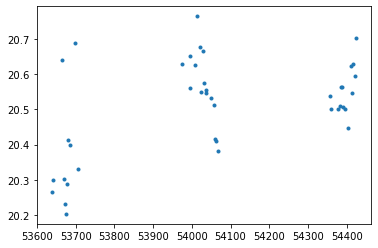

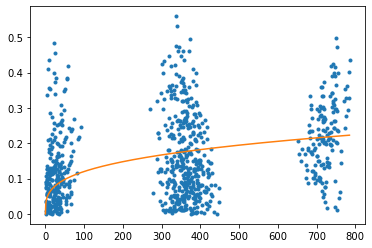

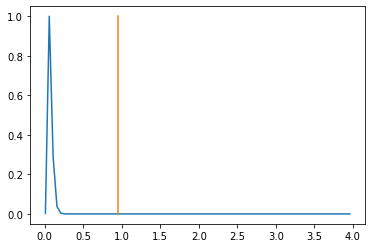

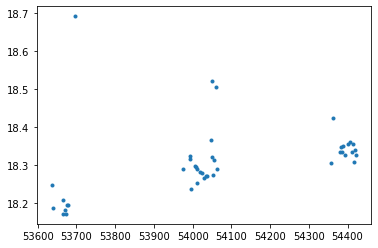

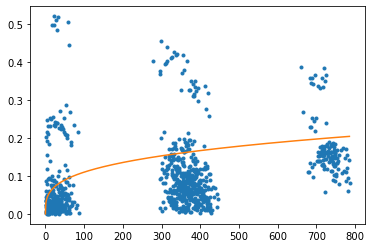

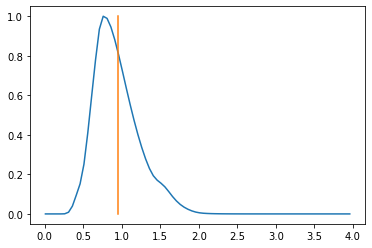

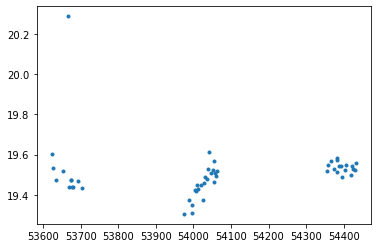

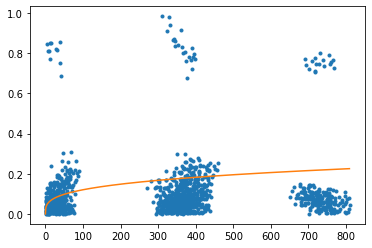

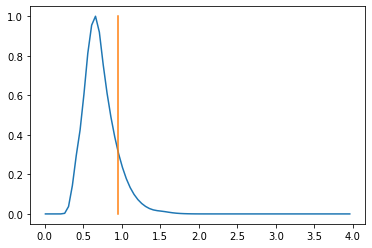

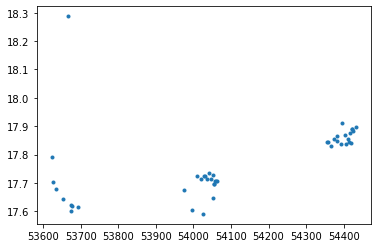

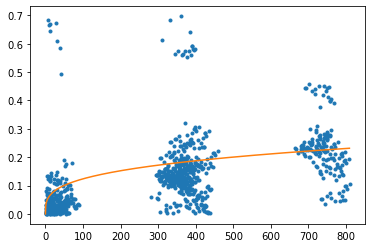

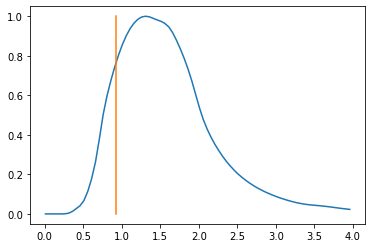

In [21]:
for k, Mi in enumerate(Mis):

    fname = fnames[k]
    lc = Table.read(fname, format='ascii')
    lc.sort('mjd', reverse=True)
    lc = lc[lc['mjd']>53500.]

    dt, mag_diff, mag_diff_err2 = get_pairs(lc)

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_obs = np.arange(0,np.max(dt),1)
    plt.plot(dt_obs, SF(dt_obs, Mi))
    plt.show()

    zs = np.arange(0.01, 4.0, 0.05)
    lPDF = np.zeros(zs.shape)
    Mi_z = get_Mi_z(mis[k], zs, Mis[k], lc['z'][0])
    for i, z in enumerate(zs):
        lPDF[i] = log_p(dt, Mi_z[i], mag_diff, mag_diff_err2)
    norm = np.max(lPDF)
    lPDF -= norm
    plt.plot(zs, np.exp(lPDF))
    plt.plot([lc['z'][0], lc['z'][0]], [0.,1.])
    plt.show()

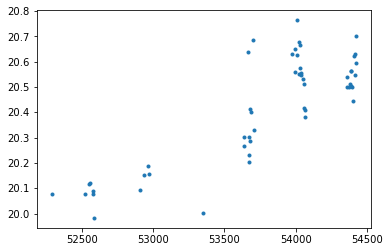

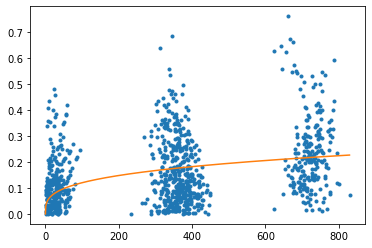

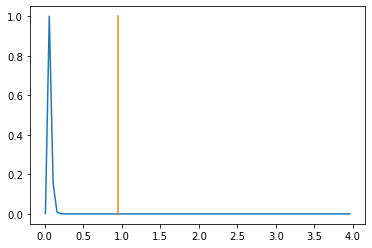

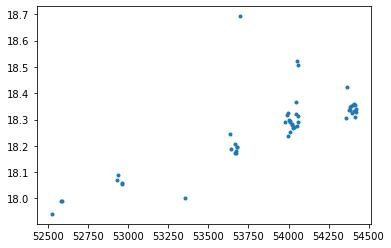

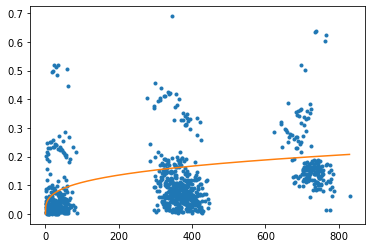

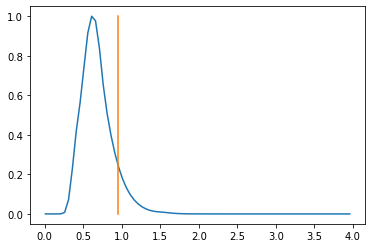

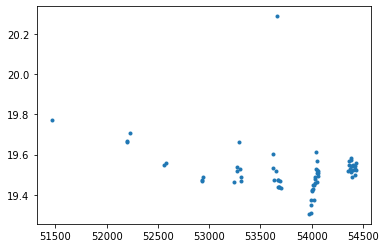

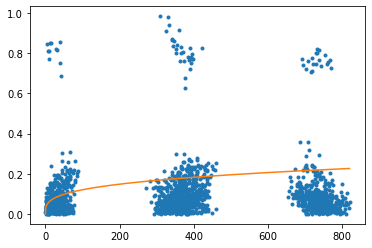

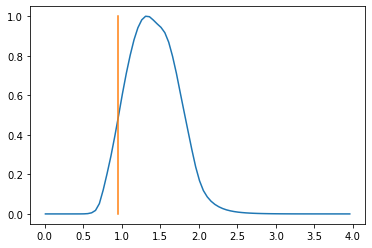

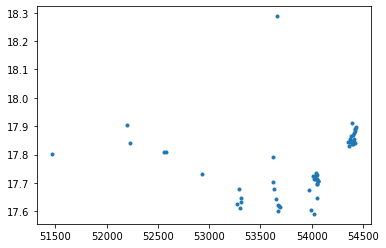

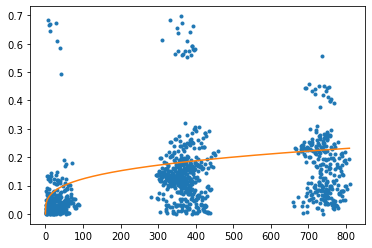

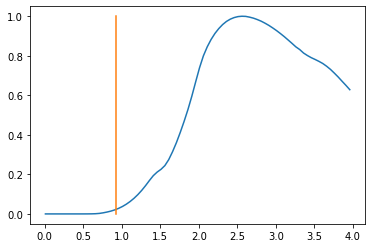

In [20]:
for k, Mi in enumerate(Mis):

    fname = fnames[k]
    lc = Table.read(fname, format='ascii')
    lc.sort('mjd', reverse=True)

    dt_all, mag_diff_all, mag_diff_err2_all = get_pairs(lc)

    cond = dt_all<1000.
    dt = dt_all[cond]
    mag_diff = mag_diff_all[cond]
    mag_diff_err2 = mag_diff_err2_all[cond]

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_obs = np.arange(0,np.max(dt),1)
    plt.plot(dt_obs, SF(dt_obs, Mi))
    plt.show()

    zs = np.arange(0.01, 4.0, 0.05)
    lPDF = np.zeros(zs.shape)
    Mi_z = get_Mi_z(mis[k], zs, Mis[k], lc['z'][0])
    for i, z in enumerate(zs):
        lPDF[i] = log_p(dt, Mi_z[i], mag_diff, mag_diff_err2)
    norm = np.max(lPDF)
    lPDF -= norm
    plt.plot(zs, np.exp(lPDF))
    plt.plot([lc['z'][0], lc['z'][0]], [0.,1.])
    plt.show()

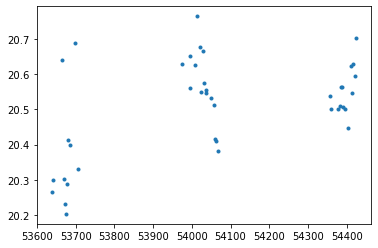

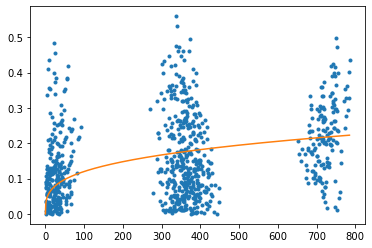

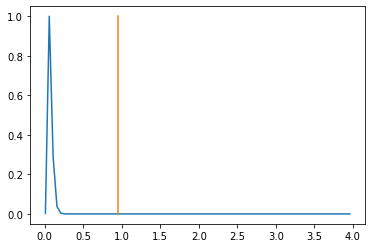

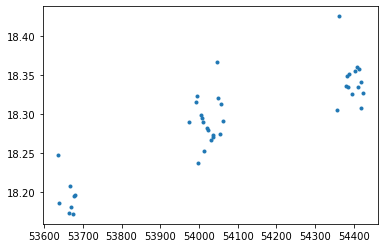

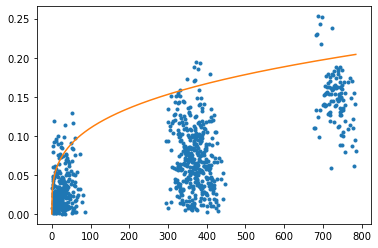

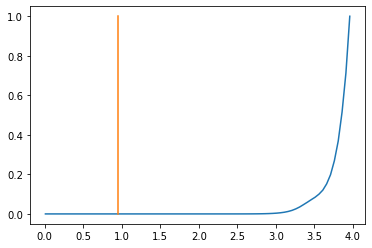

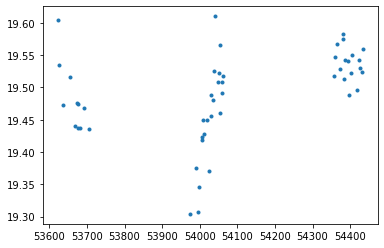

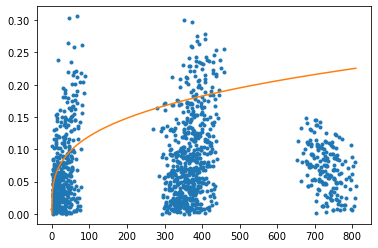

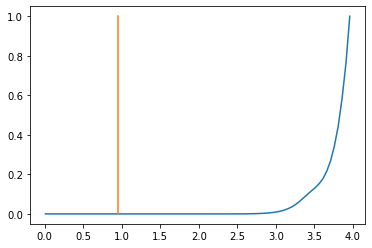

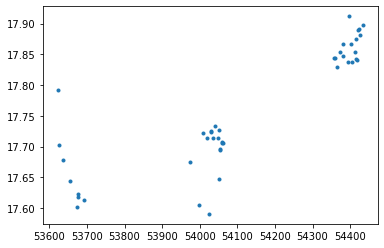

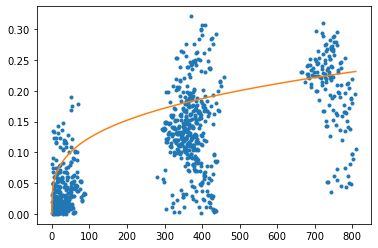

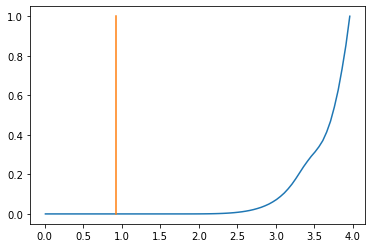

In [29]:
for k, Mi in enumerate(Mis):

    fname = fnames[k]
    lc = Table.read(fname, format='ascii')
    lc.sort('mjd')
    lc = lc[lc['mjd']>53500.]
    lc = mask_lc(lc, sigma=3.0)
    lc.sort('mjd', reverse=True)
    
    dt, mag_diff, mag_diff_err2 = get_pairs(lc)

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_obs = np.arange(0,np.max(dt),1)
    plt.plot(dt_obs, SF(dt_obs, Mi))
    plt.show()

    zs = np.arange(0.01, 4.0, 0.05)
    lPDF = np.zeros(zs.shape)
    Mi_z = get_Mi_z(mis[k], zs, Mis[k], lc['z'][0])
    for i, z in enumerate(zs):
        lPDF[i] = log_p(dt, Mi_z[i], mag_diff, mag_diff_err2)
    norm = np.max(lPDF)
    lPDF -= norm
    plt.plot(zs, np.exp(lPDF))
    plt.plot([lc['z'][0], lc['z'][0]], [0.,1.])
    plt.show()

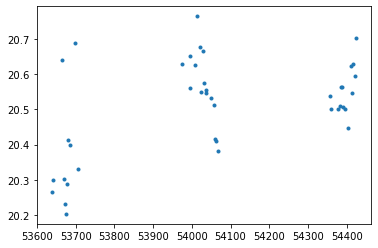

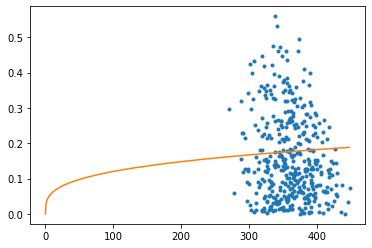

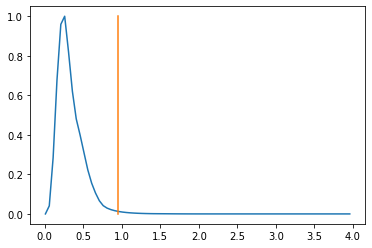

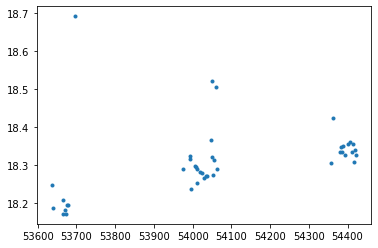

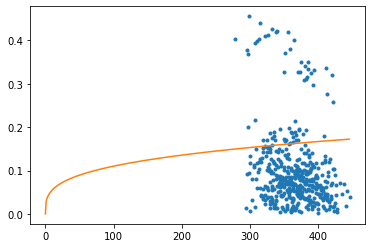

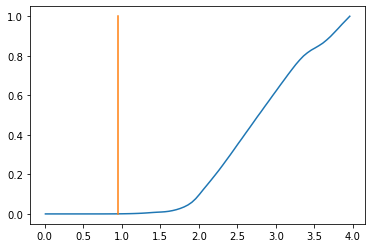

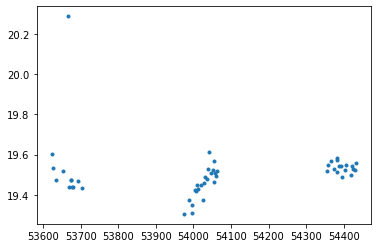

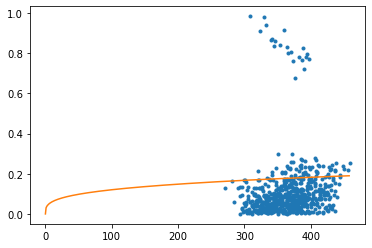

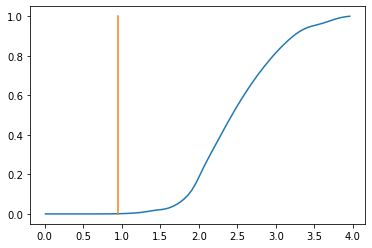

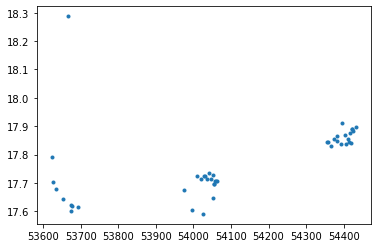

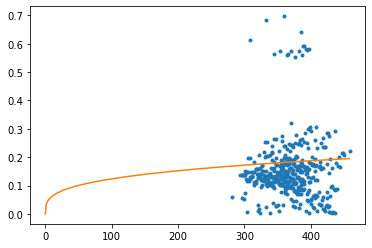

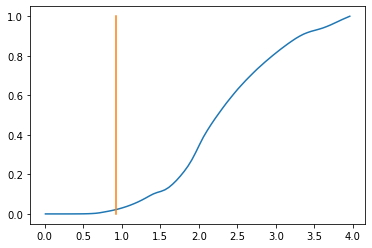

In [30]:
for k, Mi in enumerate(Mis):

    fname = fnames[k]
    lc = Table.read(fname, format='ascii')
    lc = lc[lc['mjd']>53500.]
    lc.sort('mjd', reverse=True)
    
    dt_all, mag_diff_all, mag_diff_err2_all = get_pairs(lc)

    cond = (dt_all>200) & (dt_all<600.)
    dt = dt_all[cond]
    mag_diff = mag_diff_all[cond]
    mag_diff_err2 = mag_diff_err2_all[cond]

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_obs = np.arange(0,np.max(dt),1)
    plt.plot(dt_obs, SF(dt_obs, Mi))
    plt.show()

    zs = np.arange(0.01, 4.0, 0.05)
    lPDF = np.zeros(zs.shape)
    Mi_z = get_Mi_z(mis[k], zs, Mis[k], lc['z'][0])
    for i, z in enumerate(zs):
        lPDF[i] = log_p(dt, Mi_z[i], mag_diff, mag_diff_err2)
    norm = np.max(lPDF)
    lPDF -= norm
    plt.plot(zs, np.exp(lPDF))
    plt.plot([lc['z'][0], lc['z'][0]], [0.,1.])
    plt.show()

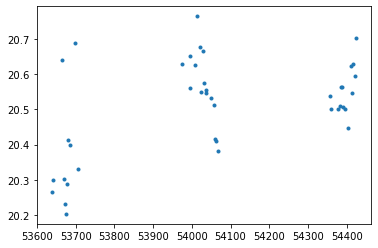

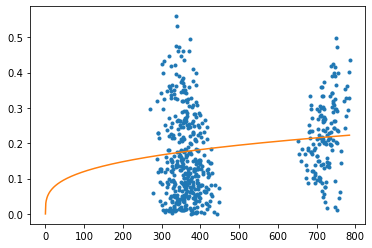

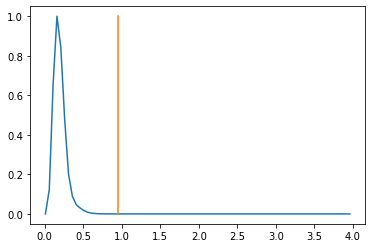

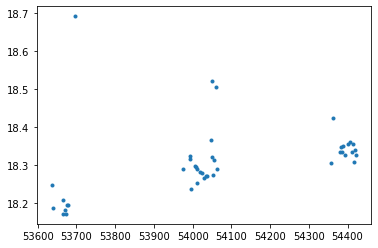

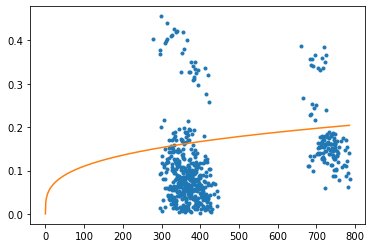

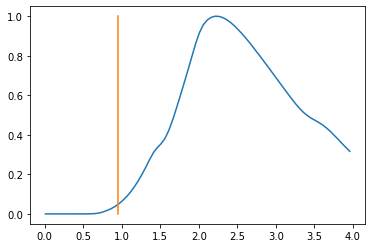

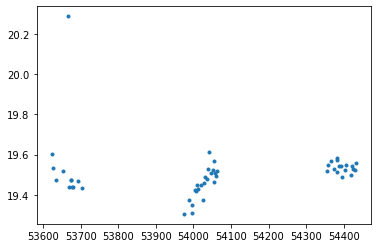

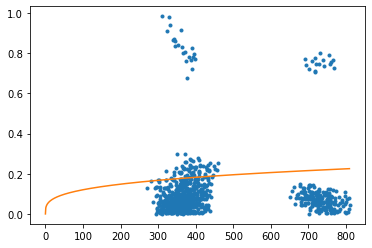

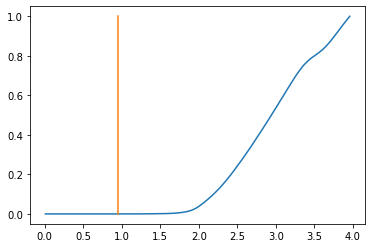

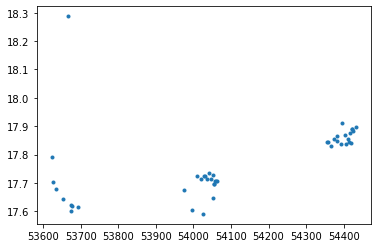

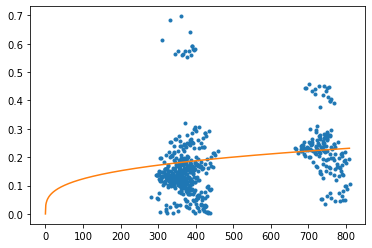

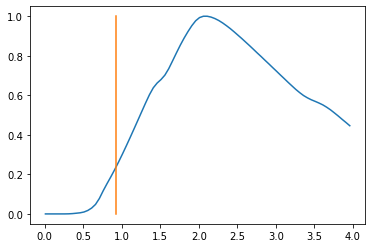

In [31]:
for k, Mi in enumerate(Mis):

    fname = fnames[k]
    lc = Table.read(fname, format='ascii')
    lc = lc[lc['mjd']>53500.]
    lc.sort('mjd', reverse=True)
    
    dt_all, mag_diff_all, mag_diff_err2_all = get_pairs(lc)

    cond = (dt_all>200) #& (dt_all<600.)
    dt = dt_all[cond]
    mag_diff = mag_diff_all[cond]
    mag_diff_err2 = mag_diff_err2_all[cond]

    plt.plot(lc['mjd'], lc['psMag'], '.')
    plt.show()

    plt.plot(dt, np.abs(mag_diff), '.')
    dt_obs = np.arange(0,np.max(dt),1)
    plt.plot(dt_obs, SF(dt_obs, Mi))
    plt.show()

    zs = np.arange(0.01, 4.0, 0.05)
    lPDF = np.zeros(zs.shape)
    Mi_z = get_Mi_z(mis[k], zs, Mis[k], lc['z'][0])
    for i, z in enumerate(zs):
        lPDF[i] = log_p(dt, Mi_z[i], mag_diff, mag_diff_err2)
    norm = np.max(lPDF)
    lPDF -= norm
    plt.plot(zs, np.exp(lPDF))
    plt.plot([lc['z'][0], lc['z'][0]], [0.,1.])
    plt.show()